In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox

In [175]:
home_dir = '/home/jupyter/data_science_projects/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

In [176]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

#df = df.loc[df.Country == 'United Kingdom']

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

#### Convenience Functions

In [177]:
def transform(data):
    """
    Purpose: Transform data using Boxcox
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox...')
    v,l = boxcox(data+.0000000001)
    print(f'Done. Optimal lamda: {l}')
    #plt.hist(v, bins = 50)
    return v

def scale(data):
    """
    Purpose: Transform data using StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    scaler = StandardScaler()
    print('Fitting StandardScaler...')
    scaled = scaler.fit_transform(data)
    #plt.hist(scaled, bins = 50)
    return data

def transform_and_scale(data):
    """
    Purpose: Transform data using Boxcox and StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox and StandardScaler...')
    data = transform(data)
    if type(data) == pd.core.series.Series:
        print('Converting Series to dataframe...')
        data = pd.DataFrame(data)
    elif type(data) == np.ndarray:
        print('Converting array to data...')
        data = pd.DataFrame(data)
    data = scale(data)
    print('Done.')
    return data

In [204]:
def plot_cluster_graph(data, transform_and_scale_data=True):
    
    """
    Purpose: Plot cluster graph
    Input: 
        data - a dataframe column
        transform_and_scale - boolean.  Default is True.  If False, data is not transformed via boxcox transform or scaled via StandardScaler
    Output: A scree plot that allows us to determine optimal number of clusters
    """
    print('Plotting cluster graph...')
    
    #Sum of Sqared Errors
    sse = {}

    if transform_and_scale_data:
        #Scales and Transforms data
        data = transform_and_scale(data)

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(data)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 5))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def assign_cluster(data, n_clusters):
    """
    Purpose: Assign cluster
    Input: 
        data - a dataframe column
        n_clusters - number of clusters
    Output:
        an array with a new column called Cluster
        """
    
    #Scales and Transforms data
    data = transform_and_scale(data)
    
    print('Assigning cluster...')
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, n_init='auto')
    
    # Predicts Cluster
    clusters = kmeans.fit_predict(data)
    
    return clusters + 1

def analyze_clusters(df,col:str, n_clusters:int):
    """
    Purpose: Analyze clusters
    Input: 
        df - a dataframe column
        col - a column name
    Output: 
        a dataframe with a new column called Cluster
        """
    output_col_name = f'{col}Cluster'
    
    df[output_col_name] = assign_cluster(df[col], n_clusters)
    
    df = df.merge(\
                  df.groupby(output_col_name, as_index=False).agg(NewCluster = (col, 'mean')).rank(), on=output_col_name, how='inner')\
                  .drop(output_col_name, axis=1)\
                  .rename(columns={'NewCluster':'RecencyCluster'})
    return df

### RECENCY, FREQUENCY, MONETARY ANALYSIS 
Objective is to find the RFM for each customer to determing Low, Medium and High Value Customers

In [179]:
new_df = df.copy()

#### Recency

In [180]:
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days

In [181]:
r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'max'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)

r_df.Recency.describe()

count    4372.000000
mean       91.047118
std       100.765435
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming using Boxcox...
Done. Optimal lamda: 0.23473423281999745
Converting array to data...
Fitting StandardScaler...
Done.


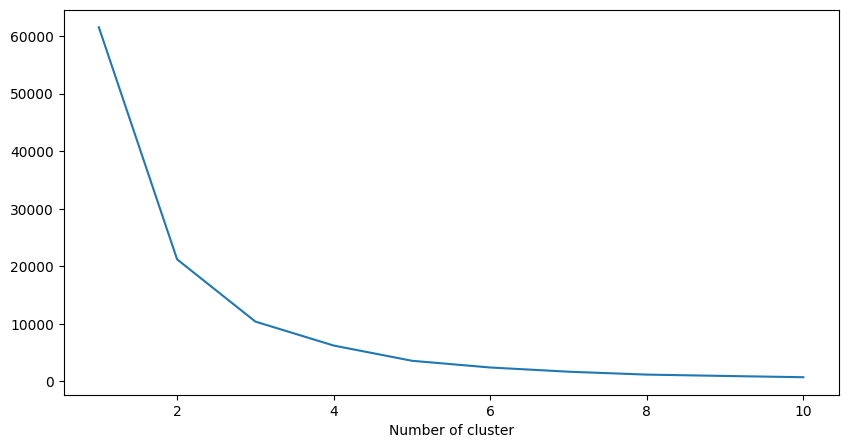

In [182]:
plot_cluster_graph(r_df['Recency'])

Scree plot shows 3 or 4 clusters would be optimal

In [209]:
analyze_clusters(r_df, 'Recency', 4)

Transforming using Boxcox and StandardScaler...
Transforming using Boxcox...
Done. Optimal lamda: 0.2852886682631543
Converting array to data...
Fitting StandardScaler...
Done.
Assigning cluster...


,CustomerID,Recency,RecencyCluster
0,12378.0,129,4.0
1,12534.0,130,4.0
2,12644.0,129,4.0
3,12750.0,128,4.0
4,12942.0,130,4.0
...,...,...,...
3214,17754.0,0,1.0
3215,17757.0,0,1.0
3216,17924.0,0,1.0
3217,17949.0,0,1.0


#### Frequency